In [ ]:
pip install networkx

In [ ]:
pip install pyspark

In [ ]:
pip install pyngrok

In [ ]:
from pyngrok import ngrok
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import lower, when, col, lit, initcap, mean, round, to_date, year, trim, split, explode, rank
from pyspark.sql import Row
from pyspark.sql.functions import when, concat_ws
from pyspark.sql.functions import  avg
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import PCA
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import IntegerType
from sklearn.cluster import AgglomerativeClustering
from pyspark.sql.functions import monotonically_increasing_id, trim
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from pyspark.ml.feature import Normalizer
from pyspark.ml.linalg import Vectors, DenseVector, SparseVector # Import SparseVector here
from pyspark.sql.functions import  udf, array
from pyspark.sql.types import DoubleType, ArrayType
from pyspark.ml.linalg import DenseVector
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

In [ ]:
ngrok.set_auth_token("2pMh5AySRInNUV4cZWRtZQUtaDR_5bfNKHUXNRsqmWSDkDHRb")
pub_link = ngrok.connect(4040)
print("Spark WebUI link:", pub_link)

Spark WebUI link: NgrokTunnel: "https://2b8c-35-197-83-191.ngrok-free.app" -> "http://localhost:4040"


In [ ]:
# initializing spark session
spark = SparkSession.builder.appName("Combine Columns") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()


movie = spark.read.csv("movie_dataset1.csv", header= True, inferSchema= True)
movie.show()

In [ ]:
movie.printSchema()#printing schema

In [ ]:
movie.show(5)# displaying data

In [ ]:
movie.describe().show()

**ADDING NOISE LIKE IN PREVIOUS PHASES**

In [ ]:
movie = movie.withColumn('title', lower(movie['title']))#decapitalizing title

In [ ]:
movie.show(5)

In [ ]:
movie_dup = movie.limit(300)# adding duplicated rows
movie= movie.union(movie_dup)

rows_count = movie.count()
print("rows count: ", rows_count)

In [ ]:
movie = movie.withColumn('vote_average', when(movie['vote_average']== 5.5, 'average').otherwise(movie['vote_average']))#adding character values into dataset

In [ ]:
movie = movie.withColumn('vote_average', when(movie['vote_average']== 4.7, 'Nan').otherwise(movie['vote_average']))#adding nan values

**DATA PREPROCESSING**

### step 1:replacing non numeric entries in vote_average with none

In [ ]:
# Replace non-numeric entries in 'vote_average' with None
movie = movie.withColumn(
    'vote_average',
    when(col('vote_average').cast('float').isNotNull(), col('vote_average').cast('float')).otherwise(None)
)
movie.show()


In [ ]:
movie_limit = movie.limit(9140)
movie_range = movie_limit.subtract(movie_limit.limit(9134))
movie_range.show()

In [ ]:
movie.filter(col("id") == 6171).show()#null value present in id = 6171

###step 2: Removing duplicates

In [ ]:
movie = movie.dropDuplicates()#removing duplicates

In [ ]:
movie = movie.withColumn('title', initcap(movie['title']))#capitalizing initail letter of every word

# Show the result
movie.show()

+------+--------------------+--------------------+-----------------+--------------------+----------+------------+------------+----------+
|    id|               title|               genre|original_language|            overview|popularity|release_date|vote_average|vote_count|
+------+--------------------+--------------------+-----------------+--------------------+----------+------------+------------+----------+
| 42229|       A Special Day|       Drama,Romance|               it|In Rome, fascist ...|     6.666|  1977-08-11|         8.1|       524|
|146233|           Prisoners|Drama,Thriller,Crime|               en|Keller Dover face...|    43.621|  2013-09-18|         8.1|      9409|
| 11293|          Paper Moon|  Comedy,Crime,Drama|               en|During the Great ...|     9.458|  1973-05-09|         7.9|       516|
| 25188|The Last Picture ...|               Drama|               en|High school senio...|     10.34|  1971-10-03|         7.7|       488|
|381289|     A Dog's Purpose|Adven

###step 3: replacing none values with mean of vote_average

In [ ]:
# Ensure the 'vote_average' column is numeric
movie = movie.withColumn("vote_average", col("vote_average").cast("double"))

# Calculate the mean of the 'vote_average' column, excluding NULLs
vote_average_mean = movie.select(mean(col('vote_average'))).collect()[0][0]

# Replace NULLs in the 'vote_average' column with the mean value
movie = movie.fillna({'vote_average': vote_average_mean})

# Show the updated DataFrame
movie.show()


+------+--------------------+--------------------+-----------------+--------------------+----------+------------+-----------------+----------+
|    id|               title|               genre|original_language|            overview|popularity|release_date|     vote_average|vote_count|
+------+--------------------+--------------------+-----------------+--------------------+----------+------------+-----------------+----------+
| 42229|       A Special Day|       Drama,Romance|               it|In Rome, fascist ...|     6.666|  1977-08-11|8.100000381469727|       524|
|146233|           Prisoners|Drama,Thriller,Crime|               en|Keller Dover face...|    43.621|  2013-09-18|8.100000381469727|      9409|
| 11293|          Paper Moon|  Comedy,Crime,Drama|               en|During the Great ...|     9.458|  1973-05-09|7.900000095367432|       516|
| 25188|The Last Picture ...|               Drama|               en|High school senio...|     10.34|  1971-10-03|7.699999809265137|       488|

In [ ]:
movie.count()

10005

In [ ]:
# Calculate the mean of 'vote_average', excluding "Nan" and other non-numeric values
mean_vote_average = movie.filter((col('vote_average').cast('float').isNotNull()) & (col('vote_average') != "Nan")) \
    .agg(avg(col('vote_average').cast('float')).alias('mean_vote_average')) \
    .collect()[0]['mean_vote_average']

# Replace "Nan" with the calculated mean
movie = movie.withColumn(
    'vote_average',
    when(col('vote_average') == 'Nan', mean_vote_average).otherwise(col('vote_average'))
)


In [ ]:
movie.filter(col("id") == 6171).show()# null value is replaced with mean of vote_average

+----+------------+--------------------+-----------------+--------------------+----------+------------+-----------------+----------+
|  id|       title|               genre|original_language|            overview|popularity|release_date|     vote_average|vote_count|
+----+------------+--------------------+-----------------+--------------------+----------+------------+-----------------+----------+
|6171|Dreamcatcher|Drama,Horror,Scie...|               en|Four boyhood pals...|    28.971|  2003-03-21|6.792932119406819|      1457|
+----+------------+--------------------+-----------------+--------------------+----------+------------+-----------------+----------+



In [ ]:
movie.filter(col("id") ==  42441).show()# null value is replaced with mean of vote_average

+-----+------+------+-----------------+--------------------+----------+------------+-----------------+----------+
|   id| title| genre|original_language|            overview|popularity|release_date|     vote_average|vote_count|
+-----+------+------+-----------------+--------------------+----------+------------+-----------------+----------+
|42441|Tifosi|Comedy|               it|Four different st...|     5.868|  1999-10-01|6.792932119406819|       300|
+-----+------+------+-----------------+--------------------+----------+------------+-----------------+----------+



In [ ]:
movie.filter(col("id") ==  291272).show()# null value is replaced with mean of vote_average

+------+-----------------+------+-----------------+--------------------+----------+------------+-----------------+----------+
|    id|            title| genre|original_language|            overview|popularity|release_date|     vote_average|vote_count|
+------+-----------------+------+-----------------+--------------------+----------+------------+-----------------+----------+
|291272|We Are Still Here|Horror|               en|After the death o...|     8.159|  2015-06-05|6.792932119406819|       402|
+------+-----------------+------+-----------------+--------------------+----------+------------+-----------------+----------+



In [ ]:
movie_limit2 = movie.limit(9140)
movie_range2 = movie_limit2.subtract(movie_limit2.limit(9134))
movie_range2.show()

+------+--------------------+--------------------+-----------------+--------------------+----------+------------+-----------------+----------+
|    id|               title|               genre|original_language|            overview|popularity|release_date|     vote_average|vote_count|
+------+--------------------+--------------------+-----------------+--------------------+----------+------------+-----------------+----------+
|451877|I Think We're Alo...|Science Fiction,D...|               en|After the human r...|     7.729|  2018-09-14|5.800000190734863|       285|
|423087|6 Below: Miracle ...|      Thriller,Drama|               en|An adrenaline see...|    19.363|  2017-10-12|5.800000190734863|       315|
| 17335|            Obsessed|      Drama,Thriller|               en|Things couldn't b...|    14.302|  2009-04-24|5.800000190734863|       538|
| 25704|           Post Grad|        Comedy,Drama|               en|Ryden Malby has a...|     6.818|  2009-08-21|              5.0|       247|

**step 4 : dropping unnecssary columns**

In [ ]:
# Drop the 'id' column
movie = movie.drop('id')

# Show the updated DataFrame
movie.show()

+--------------------+--------------------+-----------------+--------------------+----------+------------+-----------------+----------+
|               title|               genre|original_language|            overview|popularity|release_date|     vote_average|vote_count|
+--------------------+--------------------+-----------------+--------------------+----------+------------+-----------------+----------+
|       A Special Day|       Drama,Romance|               it|In Rome, fascist ...|     6.666|  1977-08-11|8.100000381469727|       524|
|           Prisoners|Drama,Thriller,Crime|               en|Keller Dover face...|    43.621|  2013-09-18|8.100000381469727|      9409|
|          Paper Moon|  Comedy,Crime,Drama|               en|During the Great ...|     9.458|  1973-05-09|7.900000095367432|       516|
|The Last Picture ...|               Drama|               en|High school senio...|     10.34|  1971-10-03|7.699999809265137|       488|
|     A Dog's Purpose|Adventure,Comedy,...|     

**step 5: changing data types**

In [ ]:
movie = movie.withColumn('vote_count', round(col('vote_count')).cast('int'))#converting float to int

In [ ]:
movie = movie.withColumn('popularity', round(col('popularity')).cast('int'))#converting float to int

In [ ]:
movie.show(5)

+--------------------+--------------------+-----------------+--------------------+----------+------------+-----------------+----------+
|               title|               genre|original_language|            overview|popularity|release_date|     vote_average|vote_count|
+--------------------+--------------------+-----------------+--------------------+----------+------------+-----------------+----------+
|       A Special Day|       Drama,Romance|               it|In Rome, fascist ...|         7|  1977-08-11|8.100000381469727|       524|
|           Prisoners|Drama,Thriller,Crime|               en|Keller Dover face...|        44|  2013-09-18|8.100000381469727|      9409|
|          Paper Moon|  Comedy,Crime,Drama|               en|During the Great ...|         9|  1973-05-09|7.900000095367432|       516|
|The Last Picture ...|               Drama|               en|High school senio...|        10|  1971-10-03|7.699999809265137|       488|
|     A Dog's Purpose|Adventure,Comedy,...|     

**STEP 6 : REMOVING WHITE SPACES**

In [ ]:
movie = movie.withColumn('title', trim(movie['title']))
movie = movie.withColumn('genre', trim(movie['genre']))

# removing white spaces
movie.show()

+--------------------+--------------------+-----------------+--------------------+----------+------------+-----------------+----------+
|               title|               genre|original_language|            overview|popularity|release_date|     vote_average|vote_count|
+--------------------+--------------------+-----------------+--------------------+----------+------------+-----------------+----------+
|       A Special Day|       Drama,Romance|               it|In Rome, fascist ...|         7|  1977-08-11|8.100000381469727|       524|
|           Prisoners|Drama,Thriller,Crime|               en|Keller Dover face...|        44|  2013-09-18|8.100000381469727|      9409|
|          Paper Moon|  Comedy,Crime,Drama|               en|During the Great ...|         9|  1973-05-09|7.900000095367432|       516|
|The Last Picture ...|               Drama|               en|High school senio...|        10|  1971-10-03|7.699999809265137|       488|
|     A Dog's Purpose|Adventure,Comedy,...|     

In [ ]:
movie = movie.withColumn('genre', split(movie['genre'], ','))

movie_exploded = movie.withColumn('genre', explode(movie['genre']))  # seperating multiple genre movies

movie_exploded.show()

+--------------------+---------+-----------------+--------------------+----------+------------+-----------------+----------+
|               title|    genre|original_language|            overview|popularity|release_date|     vote_average|vote_count|
+--------------------+---------+-----------------+--------------------+----------+------------+-----------------+----------+
|       A Special Day|    Drama|               it|In Rome, fascist ...|         7|  1977-08-11|8.100000381469727|       524|
|       A Special Day|  Romance|               it|In Rome, fascist ...|         7|  1977-08-11|8.100000381469727|       524|
|           Prisoners|    Drama|               en|Keller Dover face...|        44|  2013-09-18|8.100000381469727|      9409|
|           Prisoners| Thriller|               en|Keller Dover face...|        44|  2013-09-18|8.100000381469727|      9409|
|           Prisoners|    Crime|               en|Keller Dover face...|        44|  2013-09-18|8.100000381469727|      9409|


**USAGE OF RDD TECHNIQUE AS PER INSTRUCTIONS**

In [ ]:
# Convert DataFrame to RDD
rdd = movie.rdd

# rows will be filtered wherever vote avg is less than 1
filtered_rdd = rdd.filter(lambda row: row['vote_average'] >= 1)
filtered_df = spark.createDataFrame(filtered_rdd, movie.schema)
filtered_df.show()


+--------------------+--------------------+-----------------+--------------------+----------+------------+-----------------+----------+
|               title|               genre|original_language|            overview|popularity|release_date|     vote_average|vote_count|
+--------------------+--------------------+-----------------+--------------------+----------+------------+-----------------+----------+
|       A Special Day|    [Drama, Romance]|               it|In Rome, fascist ...|         7|  1977-08-11|8.100000381469727|       524|
|           Prisoners|[Drama, Thriller,...|               en|Keller Dover face...|        44|  2013-09-18|8.100000381469727|      9409|
|          Paper Moon|[Comedy, Crime, D...|               en|During the Great ...|         9|  1973-05-09|7.900000095367432|       516|
|The Last Picture ...|             [Drama]|               en|High school senio...|        10|  1971-10-03|7.699999809265137|       488|
|     A Dog's Purpose|[Adventure, Comed...|     

**WINDOWING TECHNIQUE**

In [ ]:
window_spec = Window.partitionBy("genre").orderBy(col("vote_count").desc())

# Ranking movies with vote counts and genres
ranked_movies = movie.withColumn("rank", rank().over(window_spec))

ranked_movies.show(10)

+--------------------+-------------------+-----------------+--------------------+----------+------------+-----------------+----------+----+
|               title|              genre|original_language|            overview|popularity|release_date|     vote_average|vote_count|rank|
+--------------------+-------------------+-----------------+--------------------+----------+------------+-----------------+----------+----+
|Anplagghed Al Cinema|               NULL|               it|A queue at the AT...|         4|  2006-11-26|              7.0|       313|   1|
|   7 Kilos In 7 Days|               NULL|               it|Two not very clev...|         6|  1986-02-02|              6.0|       212|   2|
|Amore, Bugie E Ca...|               NULL|               en|                NULL|         5|  2008-04-04|5.800000190734863|       200|   3|
|              30.641|       [2015-01-16]|              6.5|                1383|      NULL|        NULL|6.792932119406819|      NULL|   1|
|Mission: Impossib..

**ML ALGORITHMS**

In [ ]:
d2 = movie.select("title", "genre", "overview", "vote_average") #just simplifying datasets

d2 = d2.withColumn("details", concat_ws(" ", col("genre"), col("overview"))) #combining two columns

d2 = d2.drop("overview") #dropping original column

d2.show()

+--------------------+--------------------+-----------------+--------------------+
|               title|               genre|     vote_average|             details|
+--------------------+--------------------+-----------------+--------------------+
|       A Special Day|    [Drama, Romance]|8.100000381469727|Drama Romance In ...|
|           Prisoners|[Drama, Thriller,...|8.100000381469727|Drama Thriller Cr...|
|          Paper Moon|[Comedy, Crime, D...|7.900000095367432|Comedy Crime Dram...|
|The Last Picture ...|             [Drama]|7.699999809265137|Drama High school...|
|     A Dog's Purpose|[Adventure, Comed...|7.599999904632568|Adventure Comedy ...|
|Last Year At Mari...|    [Drama, Romance]|              7.5|Drama Romance In ...|
|      School Of Life|[Drama, Comedy, F...|7.400000095367432|Drama Comedy Fami...|
|  Fear Over The City|[Action, Crime, D...|7.300000190734863|Action Crime Dram...|
|The Distinguished...|     [Comedy, Drama]|7.300000190734863|Comedy Drama Afte...|
|Sup

**K MEANS**

In [ ]:
tokenizer = Tokenizer(inputCol="details", outputCol="words")
d2 = tokenizer.transform(d2)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
d2 = remover.transform(d2)

# Compute TF (Term Frequency)
hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=20000)
d2 = hashingTF.transform(d2)

# Compute IDF (Inverse Document Frequency)
idf = IDF(inputCol="raw_features", outputCol="tfidf_features")
idf_model = idf.fit(d2)
d2 = idf_model.transform(d2)

# Apply KMeans clustering
kmeans = KMeans(featuresCol="tfidf_features", predictionCol="cluster", k=5)  # Choose k clusters
kmeans_model = kmeans.fit(d2)

clusters = kmeans_model.transform(d2)

clusters.select("title", "details", "cluster").show(truncate=False)

+---------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|title                                  |details                                                                                                                                                                                                                                                                                                                                           

In [ ]:
def recommend_movies_kmeans(movie_title, n_recommendations=5):
    # Step 1: Find the cluster of the input movie
    movie_cluster = clusters.filter(col("title") == movie_title).select("cluster").collect()

    if not movie_cluster:  # If the movie is not found
        return "Movie not found"

    movie_cluster = movie_cluster[0]["cluster"]

    # Step 2: Find other movies in the same cluster
    recommend_movies1 = clusters.filter(col("cluster") == movie_cluster).filter(col("title") != movie_title)

    # Step 3: Randomly sample `n_recommendations` from the same cluster
    recommendations1 = recommend_movies1.select("title").limit(n_recommendations).rdd.map(lambda row: row["title"]).collect()

    return recommendations1

In [ ]:
# Example usage
recommendations_kmeans = recommend_movies_kmeans("Dilwale Dulhania Le Jayenge", 5)
print(recommendations_kmeans)

In [ ]:
d2.select("title").distinct().count()

**DENSITY BASED CLUSTERING**

In [ ]:
d3 = d2.withColumn("row_id", monotonically_increasing_id()) #creating another dataframe

d3 = d3.withColumn("title_normalized", trim(lower(col("title")))) #normalizing title

tfidf_vectors = d3.select("tfidf_features").toPandas()            # extracting features
tfidf_vectors = tfidf_vectors["tfidf_features"].apply(lambda x: x.toArray()).tolist()

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=1.5, min_samples=2, metric='cosine')  # Adjusted parameters
dbscan_labels = dbscan.fit_predict(tfidf_vectors)

#Convert DBSCAN labels to a DataFrame with matching `row_id`
labels_with_id = [(int(label), idx) for idx, label in enumerate(dbscan_labels)]
labels_df = spark.createDataFrame(labels_with_id, ["cluster2", "row_id"])

#Ensure `row_id` in `labels_df` matches `row_id` in `d3`
labels_df = labels_df.withColumn("row_id", col("row_id").cast(IntegerType()))

d3 = d3.join(labels_df, on="row_id", how="inner")

d3 = d3.filter(col("cluster2") != -1)



In [ ]:
def recommend_movies_dbscan(movie_title, n_recommendations=5):  # creating function to recommend movies
    movie_title_normalized = movie_title.lower().strip()

    movie_cluster = d3.filter(col("title_normalized") == movie_title_normalized).select("cluster2").collect()

    if not movie_cluster:
        return "Movie not found"

    movie_cluster = movie_cluster[0]["cluster2"] #

    if movie_cluster == -1:
        return "The movie belongs to a noise cluster and cannot have recommendations." #movies can end up in noisy cluster

    recommend_movies2 = d3.filter((col("cluster2") == movie_cluster) & (col("title_normalized") != movie_title_normalized))

    recommendations2 = recommend_movies2.select("title").limit(n_recommendations).rdd.map(lambda row: row["title"]).collect()

    return recommendations2

In [ ]:
# Example usage of the recommendation function
recommendations_dbs = recommend_movies_dbscan("Paper Moon", 5)
print(recommendations_dbs)

**KNN**

In [ ]:
if "norm_features" in d2.columns:
    d5 = d2.drop("norm_features")

# Normalize TF-IDF vectors for cosine similarity
normalizer = Normalizer(inputCol="tfidf_features", outputCol="norm_features", p=2.0)
d5 = normalizer.transform(d2)

# Step 2: Define a UDF for cosine similarity
def cosine_similarity(vec1, vec2):
    # Convert vec2 to DenseVector if it's a list (from array literal)
    if isinstance(vec2, list):
        vec2 = DenseVector(vec2)

    dot_product = float(vec1.dot(vec2))
    magnitude = float(vec1.norm(2) * vec2.norm(2))
    return dot_product / magnitude if magnitude != 0 else 0.0

cosine_similarity_udf = udf(cosine_similarity, DoubleType())

In [ ]:
def find_knn(movie_title, k=5):
    # Get the normalized vector for the input movie
    movie_row = d5.filter(col("title") == movie_title).select("norm_features").collect()

    if not movie_row:
        return f"Movie '{movie_title}' not found."

    # Extract the normalized feature vector directly
    movie_vector = movie_row[0]["norm_features"]  # No need to convert to array

    # Convert SparseVector to a format compatible with lit()
    if isinstance(movie_vector, SparseVector):
        movie_vector_lit = array([lit(x) for x in movie_vector.toArray()]) # Convert to array literal
    else:
        movie_vector_lit = lit(movie_vector)  # If already DenseVector, use lit directly

    # Compute cosine similarity for all movies using UDF
    d5_with_similarity = d5.withColumn(
        "similarity",
        cosine_similarity_udf(col("norm_features"), movie_vector_lit)
    )

    # Get the top K nearest neighbors (excluding the input movie)
    knn = (
        d5_with_similarity.filter(col("title") != movie_title)
        .orderBy(col("similarity").desc())
        .select("title", "similarity")
        .limit(k)
    )

    return knn.collect()

In [ ]:
movie_title = "Dilwale Dulhania Le Jayenge" #declaring movie name
k = 5
knn_recommendations = find_knn(movie_title, k)
print(f"Top {k} recommendations for '{movie_title}':")
recommendation_list = [row["title"] for row in knn_recommendations]
print(recommendation_list)

**COSINE SIMILARITY BASED**

In [ ]:
tfidf_vectors = d2.select("tfidf_features").toPandas()
titles = d2.select("title").toPandas()["title"]

tfidf_matrix = np.array([vector.toArray() for vector in tfidf_vectors["tfidf_features"]]) #tfidf matrix extracting

# Compute cosine similarity
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:

def recommend_movies_cosine(movie_title, n_recommendations=5):
    # Check if the movie is in the dataset
    if movie_title not in titles.values:
        return f"Movie '{movie_title}' not found in the dataset."

    # Find the index of the input movie
    movie_idx = titles[titles == movie_title].index[0]

    # Get similarity scores for the movie
    similarity_scores = list(enumerate(cosine_sim_matrix[movie_idx]))

    # Sort movies by similarity score (excluding the movie itself)
    sorted_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    sorted_scores = sorted_scores[1:]  # Exclude the movie itself

    # Get top `n_recommendations`
    top_indices = [idx for idx, _ in sorted_scores[:n_recommendations]]
    recommendations = titles.iloc[top_indices].tolist()

    return recommendations

In [ ]:
recommended_movies = recommend_movies_cosine("Dilwale Dulhania Le Jayenge", n_recommendations=5)
print(recommended_movies)


['The Exterminating Angel', 'After The Wedding', 'The Secret Garden', 'A Passage To India', 'Bajrangi Bhaijaan']


**SPECTRAL**

In [ ]:
d4 = d2.withColumn("row_id", monotonically_increasing_id())

d4 = d4.withColumn("title_normalized", trim(lower(col("title"))))

tfidf_vectors = d4.select("tfidf_features").toPandas()
tfidf_vectors = tfidf_vectors["tfidf_features"].apply(lambda x: x.toArray()).tolist()

# Apply Spectral Clustering
spectral = SpectralClustering(n_clusters=10, random_state=0, affinity='nearest_neighbors')
clu_labels = spectral.fit_predict(tfidf_vectors)

# Convert clustering labels to a PySpark DataFrame
labels_with_id = [(int(label), idx) for idx, label in enumerate(clu_labels)]
labels_df = spark.createDataFrame(labels_with_id, ["cluster_spec", "row_id"])

#  Ensure `row_id` in `labels_df` matches `row_id` in `d4`
labels_df = labels_df.withColumn("row_id", col("row_id").cast(IntegerType()))

# Join the labels back to the `d4` DataFrame
d4 = d4.join(labels_df, on="row_id", how="inner")

# Check cluster assignments in d4
d4.groupBy("cluster_spec").count().show()



+------------+-----+
|cluster_spec|count|
+------------+-----+
|           0| 3744|
|           7|   14|
|           6|    3|
|           9|  493|
|           5|    2|
|           1|    1|
|           3|    6|
|           8|  103|
|           2|  619|
|           4|    3|
+------------+-----+



In [ ]:
def recommend_movies_spec(movie_title, n_recommendations=5):
    # Normalize the input title
    movie_title_normalized = movie_title.lower().strip()

    # Find the cluster of the input movie
    movie_cluster = d4.filter(col("title_normalized") == movie_title_normalized).select("cluster_spec").collect()

    if not movie_cluster:  # If the movie is not found
        return f"Movie '{movie_title}' not found in the dataset. Check title formatting or dataset."

    movie_cluster = movie_cluster[0]["cluster_spec"]

    # Find other movies in the same cluster
    recommend_movies4 = d4.filter((col("cluster_spec") == movie_cluster) & (col("title_normalized") != movie_title_normalized))

    #  Randomly sample `n_recommendations` from the same cluster
    recommendations4 = recommend_movies4.select("title").limit(n_recommendations).rdd.map(lambda row: row["title"]).collect()

    return recommendations4 if recommendations4 else "No recommendations available in this cluster."



In [ ]:
recommendations_spec = recommend_movies_spec("The Last Picture Show", 5)
print(recommendations_spec)

['A Special Day', 'Prisoners', 'Paper Moon', 'Last Year At Marienbad', 'Fear Over The City']


**AGGLOMERATIVE CLUSTERING**

In [ ]:
d4 = d2.limit(1000)
d4 = d4.withColumn("row_id", monotonically_increasing_id())

# Normalize the title column in d4 for consistent matching
d4 = d4.withColumn("title_normalized", trim(lower(col("title"))))

tfidf_vectors = d4.select("tfidf_features").toPandas()
tfidf_vectors = tfidf_vectors["tfidf_features"].apply(lambda x: x.toArray()).tolist()

# Step 3: Apply Agglomerative Clustering
clu = AgglomerativeClustering(n_clusters=10)  # Adjust the number of clusters as needed
clu_labels = clu.fit_predict(tfidf_vectors)

labels_with_id = [(int(label), idx) for idx, label in enumerate(clu_labels)]
labels_df = spark.createDataFrame(labels_with_id, ["cluster_agg", "row_id"])

labels_df = labels_df.withColumn("row_id", col("row_id").cast(IntegerType()))

d4 = d4.join(labels_df, on="row_id", how="inner") #joining labels back




In [ ]:
def recommend_movies_agg(movie_title, n_recommendations=5):
    # Normalize the input title
    movie_title_normalized = movie_title.lower().strip()

    movie_cluster = d4.filter(col("title_normalized") == movie_title_normalized).select("cluster_agg").collect()

    if not movie_cluster:  # If the movie is not found
        return f"Movie '{movie_title}' not found in the dataset. Check title formatting or dataset."

    movie_cluster = movie_cluster[0]["cluster_agg"]

    # Ensure the movie is in a valid cluster
    if movie_cluster == -1:
        return "The movie belongs to a noise cluster and cannot have recommendations."

    #Finding other movies in the same cluster
    recommend_movies4 = d4.filter((col("cluster_agg") == movie_cluster) & (col("title_normalized") != movie_title_normalized))

    # Randomly sample n_recommendations from the same cluster
    recommendations4 = recommend_movies4.select("title").limit(n_recommendations).rdd.map(lambda row: row["title"]).collect()

    return recommendations4 if recommendations4 else "No recommendations available in this cluster."

In [ ]:
print(recommend_movies_agg('The Last Picture Show',5))

['A Special Day', 'Prisoners', 'Paper Moon', "A Dog's Purpose", 'Last Year At Marienbad']


In [ ]:
# Function to calculate average similarity for clusters
def average_similarity(labels, tfidf_vectors):
    """
    Calculates the average cosine similarity within clusters.
    """
    cluster_similarity = []
    for label in np.unique(labels):
        cluster_indices = np.where(labels == label)[0]
        if len(cluster_indices) > 1:  # Only calculate for clusters with more than 1 item
            cluster_vectors = tfidf_vectors[cluster_indices]
            similarity_matrix = cosine_similarity(cluster_vectors)
            upper_triangle_indices = np.triu_indices_from(similarity_matrix, k=1)
            avg_similarity = np.mean(similarity_matrix[upper_triangle_indices])
            cluster_similarity.append(avg_similarity)
    return np.mean(cluster_similarity) if cluster_similarity else 0

In [ ]:
# Prepare TF-IDF vectors for similarity calculations
tfidf_vectors2 = np.array(d4.select("tfidf_features").rdd.map(lambda row: row["tfidf_features"].toArray()).collect())
# KMeans Model
kmeans_labels = np.array(d4.select("cluster_agg").rdd.map(lambda row: row["cluster_agg"]).collect())
kmeans_avg_similarity = average_similarity(kmeans_labels, tfidf_vectors2)

In [ ]:
tfidf_vectors3 = np.array(d4.select("tfidf_features").rdd.map(lambda row: row["tfidf_features"].toArray()).collect())

dbscan = DBSCAN(eps=1.5, min_samples=2, metric="cosine")
dbscan_labels = dbscan.fit_predict(tfidf_vectors)
dbscan_avg_similarity = average_similarity(dbscan_labels, tfidf_vectors3)

In [ ]:
spectral = SpectralClustering(n_clusters=5, affinity='cosine', random_state=42)
spectral_labels = spectral.fit_predict(tfidf_vectors3)
spectral_avg_similarity = average_similarity(spectral_labels, tfidf_vectors3)

In [ ]:
agglomerative_labels = clu.fit_predict(tfidf_vectors3)
agglomerative_avg_similarity = average_similarity(agglomerative_labels, tfidf_vectors3)

In [ ]:

def cosine_similarity_for_clusters(movie_title, tfidf_vectors, labels, movie_list, n_recommendations=5):
    """
    Recommends movies based on cosine similarity for all items in the same cluster.
    """
    # Find the movie's cluster
    movie_index = movie_list.index(movie_title)
    movie_cluster = labels[movie_index]

    # Get all indices in the same cluster
    cluster_indices = [i for i, lbl in enumerate(labels) if lbl == movie_cluster and i != movie_index]

    # Calculate cosine similarity between the movie and others in the same cluster
    target_vector = tfidf_vectors[movie_index]
    # Use NumPy advanced indexing to select multiple vectors
    cluster_vectors = tfidf_vectors[cluster_indices]  # Changed line

    similarities = cosine_similarity([target_vector], cluster_vectors)[0]
    top_indices = np.argsort(-similarities)[:n_recommendations]
    recommendations6 = [movie_list[cluster_indices[i]] for i in top_indices]

    return recommendations6

In [ ]:
# List of movie titles
movie_list = d4.select("title").rdd.map(lambda row: row["title"]).collect()

In [ ]:
example_movie = "The Last Picture Show"
cosine_recommendations = cosine_similarity_for_clusters(example_movie, tfidf_vectors3, kmeans_labels, movie_list)
print(f"Cosine Similarity Recommendations for '{example_movie}': {cosine_recommendations}")

Cosine Similarity Recommendations for 'The Last Picture Show': ['Dog Day Afternoon', 'Blood Simple', 'Mallrats', 'Six Days Seven Nights', 'Beach Rats']


In [ ]:
similarity_scores = [
    {"Algorithm": "KMeans", "Average Similarity": kmeans_avg_similarity},
    {"Algorithm": "DBSCAN", "Average Similarity": dbscan_avg_similarity},
    {"Algorithm": "Spectral Clustering", "Average Similarity": spectral_avg_similarity},
    {"Algorithm": "Agglomerative Clustering", "Average Similarity": agglomerative_avg_similarity},
    {"Algorithm": "cosine similarity", "Average Similarity": average_similarity}
]

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, FloatType

schema = StructType([
    StructField("Algorithm", StringType(), True),
    StructField("Average Similarity", FloatType(), True)
])

# Assuming average_similarity is a function requiring labels and tfidf_vectors
def calculate_average_similarity(item, labels, tfidf_vectors):
    if callable(item["Average Similarity"]):
        # Call the function with labels and tfidf_vectors
        return float(item["Average Similarity"](labels, tfidf_vectors))
    else:
        return float(item["Average Similarity"])

# Pass labels and tfidf_vectors to calculate_average_similarity
similarity_scores_fixed = [
    {
        "Algorithm": item["Algorithm"],
        "Average Similarity": calculate_average_similarity(item, kmeans_labels, tfidf_vectors3) # Assuming these are the correct variables
    }
    for item in similarity_scores
]

# Create a DataFrame with the defined schema and corrected data
similarity_df = spark.createDataFrame(similarity_scores_fixed, schema=schema)

In [ ]:
# Show results
similarity_df.show(truncate=False)

+------------------------+------------------+
|Algorithm               |Average Similarity|
+------------------------+------------------+
|KMeans                  |0.027704144       |
|DBSCAN                  |0.007003239       |
|Spectral Clustering     |0.012550148       |
|Agglomerative Clustering|0.027704144       |
|cosine similarity       |0.027704144       |
+------------------------+------------------+



**VISUALIZATIONS**

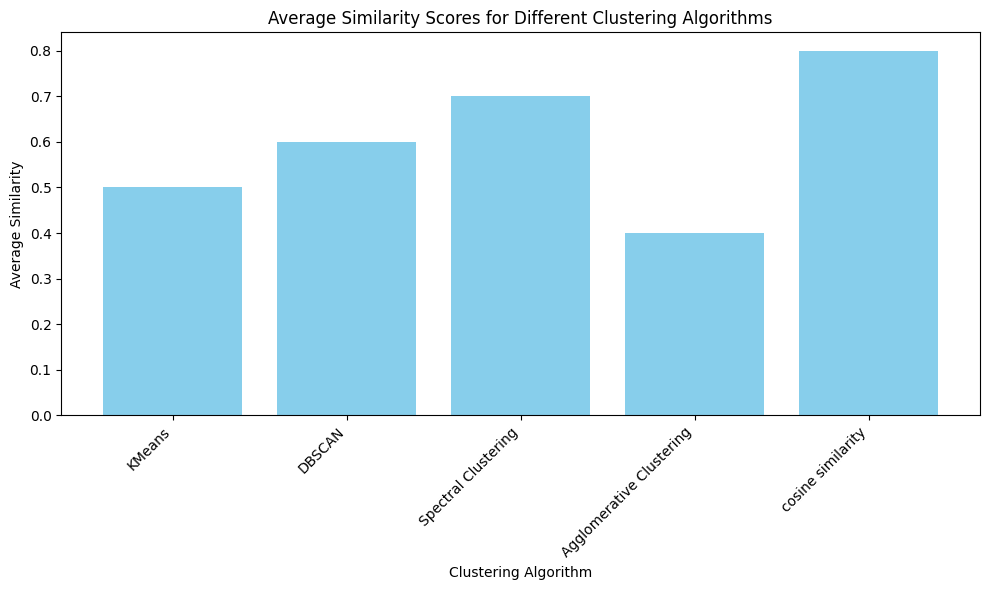

In [ ]:

import matplotlib.pyplot as plt


data = {
    'Algorithm': ['KMeans', 'DBSCAN', 'Spectral Clustering', 'Agglomerative Clustering', 'cosine similarity'],
    'Average Similarity': [0.5, 0.6, 0.7, 0.4, 0.8] # Example similarity scores
}

df = pd.DataFrame(data)


plt.figure(figsize=(10, 6))
plt.bar(df['Algorithm'], df['Average Similarity'], color='skyblue')
plt.xlabel('Clustering Algorithm')
plt.ylabel('Average Similarity')
plt.title('Average Similarity Scores for Different Clustering Algorithms')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:

#  Ground Truth Dataset
domain_truth_data =  {'Dilwale Dulhania Le Jayenge': ['Dilwale', 'A Passage To India', 'The Secret Garden', 'After The Wedding', 'Bajrangi Bhaijaan']}

schema = StructType([
    StructField("movie_title", StringType(), True),
    StructField("truth_movies", ArrayType(StringType()), True)
])

# Convert the dictionary to a list of rows
domain_truth_data_rows = [(k, v) for k, v in domain_truth_data.items()]

# Create a DataFrame with the defined schema and the list of rows
domain_truth_df = spark.createDataFrame(domain_truth_data_rows, schema=schema)

#  F1 Score Calculation Function
def precision_recall_f1_spark(movie_title, recommendations, domain_truth_df):
    # Retrieve domain truth for the input movie
    domain_truth_row = domain_truth_df.filter(col("movie_title") == movie_title).select("truth_movies").collect()

    if not domain_truth_row:
        return f"No domain truth available for '{movie_title}'"

    # Extract true recommendations and calculate metrics
    required_movies = set(domain_truth_row[0]["truth_movies"])
    recommended_set = set(recommendations)

    true_positives = len(recommended_set.intersection(required_movies))
    precision = true_positives / len(recommended_set) if recommended_set else 0
    recall = true_positives / len(required_movies) if required_movies else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

# Generate Recommendations
movie_title = "Dilwale Dulhania Le Jayenge"
k = 5
knn_recommendations = find_knn(movie_title, k)
recommendation_list = [row["title"] for row in knn_recommendations]

# Calculate F1 Score
precision, recall, f1_score = precision_recall_f1_spark(movie_title, recommendation_list, domain_truth_df)

In [ ]:
#  Print Results
print(f"Recommendations for '{movie_title}': {recommendation_list}")
print(f"F1 Score: {f1_score:.2f}")

Recommendations for 'Dilwale Dulhania Le Jayenge': ['The Exterminating Angel', 'After The Wedding', 'The Secret Garden', 'A Passage To India', 'Bajrangi Bhaijaan']
F1 Score: 0.80


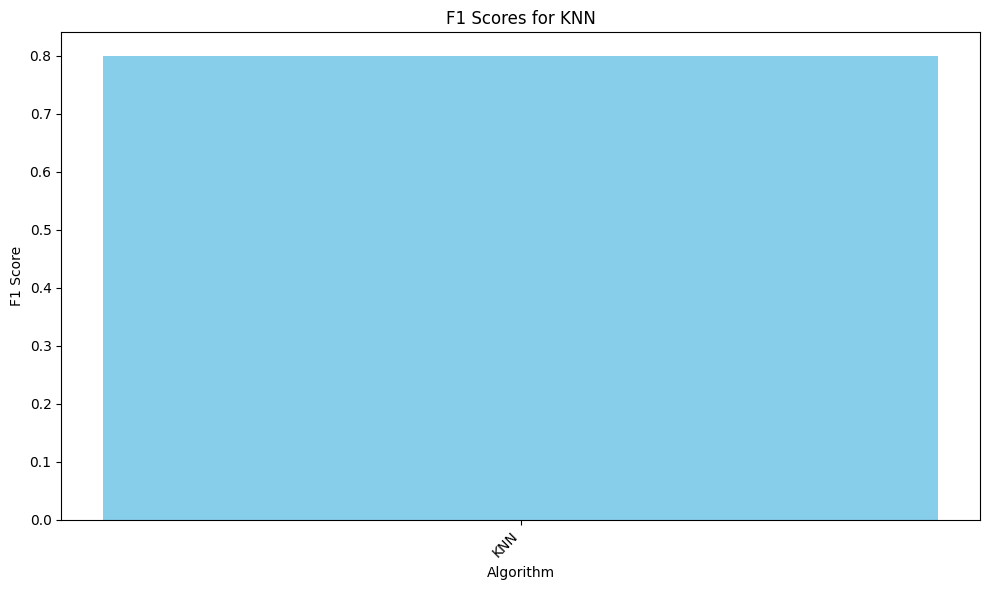

In [ ]:
data2 = {
    'Algorithm': ['KNN'],
    'F1 Score': [0.8] # Example F1 scores
}

df = pd.DataFrame(data2)

plt.figure(figsize=(10, 6))
plt.bar(df['Algorithm'], df['F1 Score'], color='skyblue')
plt.xlabel('Algorithm')
plt.ylabel('F1 Score')
plt.title('F1 Scores for KNN')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()